<a href="https://colab.research.google.com/github/gabrielbklopes/KFSimulationGPS/blob/main/KFSimulationGPS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kalman Filter GPS

Developed by Gabriel Lopes

This notebook implements a Simple Kalman Filter for a GPS Tracking System, the latitude and longitude values are decomposed in distance and angle and then the filter is feeded with position and velocity in North and East values.

The csv file must be in the form of (latitude, longitude, velocity, aceleration) where velocity and aceleration are the paralel vectors to the car moviment. 

In [ ]:
!pip install haversine

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from numpy import genfromtxt
from scipy.linalg import expm, block_diag, inv
from numpy.random import randn
from haversine import haversine, Unit

from google.colab import files
uploaded = files.upload()
#data = pd.read_csv("dados_gps_namorada_perda.csv")
my_data = np.loadtxt('gps_test_0105.csv', delimiter=',')
print(len(my_data))

Saving gps_test_0105.csv to gps_test_0105.csv
876




---


In the cell bellow we implement the matrix ***Q*** none as the Process Covariance Matrix. 

It's equation is coming from:


```
P = F @ P @ F.T + Q
```



Where @ is a matrix multiplication. 


In [ ]:
def order_by_derivative(Q, dim, block_size):
    N = dim * block_size
    D = zeros((N, N))
    Q = array(Q)
    for i, x in enumerate(Q.ravel()):
        f = eye(block_size) * x
        ix, iy = (i // dim) * block_size, (i % dim) * block_size
        D[ix:ix+block_size, iy:iy+block_size] = f
    return 

def Q_discrete_white_noise(dim, dt=1., var=1., block_size=1, order_by_dim=True):
    if dim not in [2, 3, 4]:
        raise ValueError("dim must be between 2 and 4")
    if dim == 2:
        Q = [[.25*dt**4, .5*dt**3],
             [ .5*dt**3,    dt**2]]
    elif dim == 3:
        Q = [[.25*dt**4, .5*dt**3, .5*dt**2],
             [ .5*dt**3,    dt**2,       dt],
             [ .5*dt**2,       dt,        1]]
    else:
        Q = [[(dt**6)/36, (dt**5)/12, (dt**4)/6, (dt**3)/6],
             [(dt**5)/12, (dt**4)/4,  (dt**3)/2, (dt**2)/2],
             [(dt**4)/6,  (dt**3)/2,   dt**2,     dt],
             [(dt**3)/6,  (dt**2)/2 ,  dt,        1.]]
    if order_by_dim:
        return block_diag(*[Q]*block_size) * var
    return order_by_derivative(array(Q), dim, block_size) * var



---


For this cell the bearing and distance between two points in space are calculated. 

For a short summury, considering two points in the globe as P1 = (𝛗1, 𝛌1) and P2 = (𝛗2, 𝛌2) the distance between the two points can be calculated using the law of cossines for a spherical triangle. One of the sides is paste in the north line and the other sides are the points P1,P2.

https://en.wikipedia.org/wiki/Spherical_law_of_cosines

The bearing angle is needed to understand the direction of moviment the object is doing in the espheroid. That angle will be necessary to determinate the North and East deslocations of the object. 

https://www.bbc.co.uk/bitesize/guides/zqwhjty/revision/2



In [ ]:
def get_bearing(lat1, long1, lat2, long2):
    dLon = (long2 - long1)
    x = math.cos(math.radians(lat2)) * math.sin(math.radians(dLon))
    y = math.cos(math.radians(lat1)) * math.sin(math.radians(lat2)) - math.sin(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.cos(math.radians(dLon))
    brng = np.arctan2(x,y)
    brng = np.degrees(brng)

    return brng

def getNorthish(lat1, long1, lat2, long2):
  pos1 = (lat1, long1)
  pos2 = (lat2, long2)

  aN = haversine(pos1, pos2)*1000
  bN = get_bearing(lat1, long1, lat2, long2)

  return (aN, bN)

def getEasthish(lat1, long1, lat2, long2):
  pos1 = (lat1, long1)
  pos2 = (lat2, long2)

  aE = haversine(pos1, pos2)*1000
  bE = get_bearing(lat1, long1, lat2, long2)

  return(aE, bE)




---



---
In the cell bellow we implement the Kalman Filter Functions. You must inform all the matrices for the function in order to work.

If you have douts about how a Kalman Filter works, you must do some research on it. I pasted a link to help you start.

https://www.kalmanfilter.net/default.aspx

I hope this simple Kalman Filter here will evolve to a Extended or a Unscented Kalman Filer.


---




In [ ]:
def predict(x, P, F, Q, B, u):
  x = F @ x + np.multiply(B, u)
  P =  F @ P @ F.T + Q
  return x, P

def update(x, P, H, R, z):
  S = H @ P @ H.T + R
  K = P @ H.T @ inv(S)
  
  y = z - (H @ x).T
  x += K @ y.T
  P = P - K @ H @ P
  return x, P

Those are the matrices for the problem.

Change the time **dt** to the time of your sampling.

In [ ]:
dt = 0.20

#design state transition function
F = np.array([[1, dt],
              [0,  1]])

B = np.array([[(dt**2)/2, dt]]).T

H = np.array([[1., 0],
              [0, 1.]])

R = np.array([[5, 0.],
             [0., 5]])
#state matriz for N and E
x_N = np.array([[0., 0.]]).T
x_E = np.array([[0., 0.]]).T

#corariance matriz for N and E
P_N = np.diag([100., 100.])
P_E = np.diag([100., 100.])

# DEFINE Q MATRIX
Q = Q_discrete_white_noise(dim=2, dt=dt, var=0.5)

Run this cell to calculate the Filter.

In [ ]:
measuN, xsN, covN, erroN = [], [], [], []
errN = 0

measuE, xsE, covE, erroE = [], [], [], []
errE = 0

i = 1
N, E = 0, 0

while(i < len(my_data)):
  for j in range(2):
    if j == 0:
      Nmod, Nangle = getNorthish(my_data[i-1, 0], my_data[i-1, 1], my_data[i, 0], my_data[i, 1])
      Ndist = Nmod*math.cos(Nangle)
      N += Ndist
      vN = my_data[i, 2]*math.cos(Nangle)
      aN = (my_data[i, 3]*math.cos(Nangle))
      z = (N, vN)
      x_N, P_N = predict(x_N, P_N, F, Q, B, aN)
      x_N, P_N = update(x_N, P_N, H, R, z)

      measuN.append(z)
      xsN.append(x_N)
      covN.append(P_N)

      errN = abs((x_N[0] - z[0]))
      erroN.append(errN)

    else:
      Emod, Eangle = getEasthish(my_data[i-1, 0], my_data[i-1, 1], my_data[i, 0], my_data[i, 1])
      Edist = Emod*math.sin(Eangle)
      E += Edist
      vE = my_data[i, 2]*math.sin(Nangle)
      aE = (my_data[i, 3]*math.sin(Nangle))
      z = (E, vE)
      x_E, P_E = predict(x_E, P_E, F, Q, B, aE)
      x_E, P_E = update(x_E, P_E, H, R, z)

      measuE.append(z)
      xsE.append(x_E)
      covE.append(P_E)

      errE = abs((x_E[0] - z[0]))
      erroE.append(errE)

  i += 1


measuN = np.asarray(measuN)
xsN = np.asarray(xsN)
covN = np.asarray(covN)

measuE = np.asarray(measuE)
xsE = np.asarray(xsE)
covE = np.asarray(covE)

[array([159.80863336]), array([139.50772527]), array([120.7796498]), array([103.59451162]), array([87.90920065]), array([73.74462219]), array([60.87822332]), array([49.32844841]), array([39.02234306]), array([29.88398523]), array([21.45705554]), array([14.47223534]), array([8.41788798]), array([3.21797778]), array([1.20149422]), array([3.59503845]), array([6.84522895]), array([9.50476636]), array([11.63566213]), array([13.51732544]), array([14.73259152]), array([15.5856557]), array([16.12357684]), array([16.38967212]), array([15.52119827]), array([15.48037069]), array([15.26620759]), array([14.90845679]), array([14.43385493]), array([16.217197]), array([15.26263392]), array([14.28096951]), array([13.28786506]), array([12.29665163]), array([15.53014221]), array([14.00647022]), array([12.55978876]), array([11.19478805]), array([9.91447217]), array([13.50904574]), array([11.75761208]), array([10.14510323]), array([8.66839438]), array([7.32327527]), array([11.39620597]), array([9.58813194]

printRun this cell to generate the graphics.

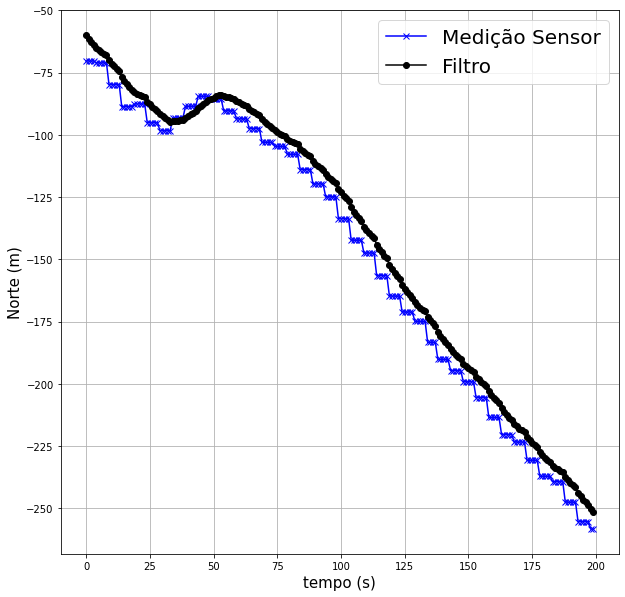

<Figure size 432x288 with 0 Axes>

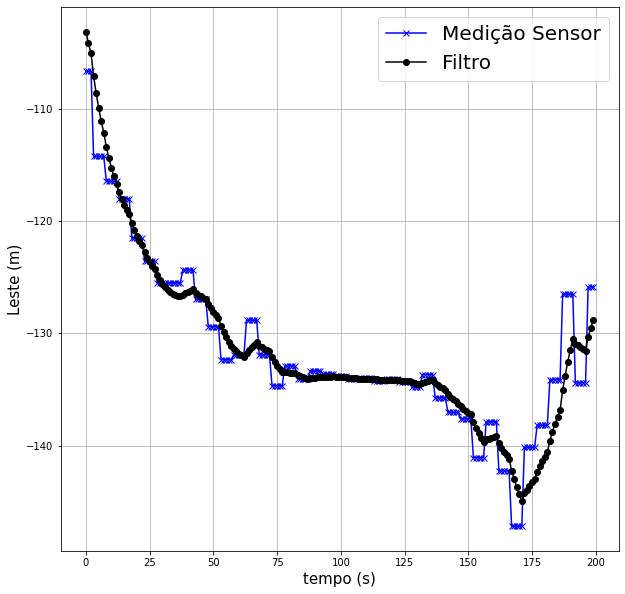

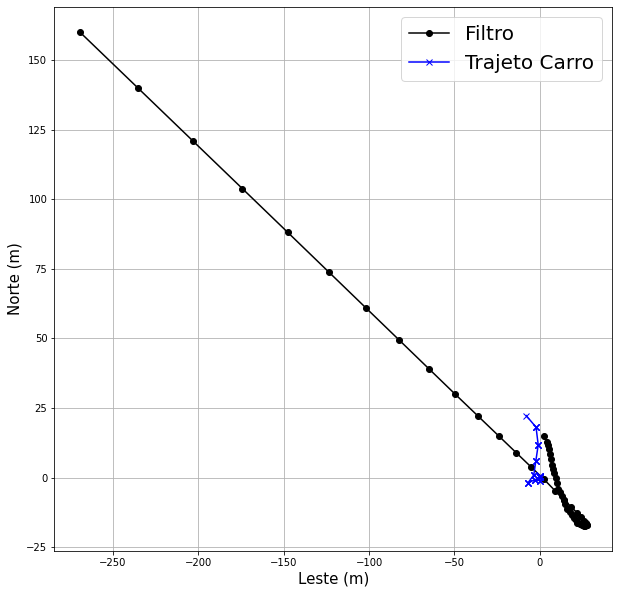

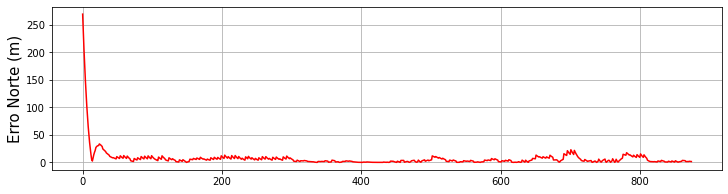

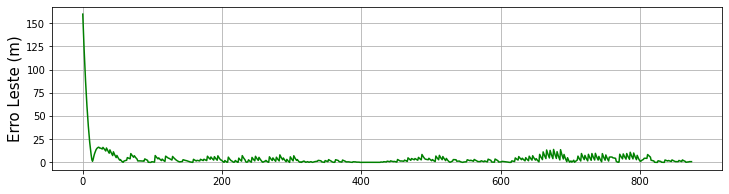

In [116]:
MEDIUM_SIZE = 15
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels

fig,ax = plt.subplots()
ax.grid()
ax.plot(measuN[100:300,0] , "x-", color="blue", label='Medição Sensor')
ax.plot(xsN[100:300,0] , "ko-", label='Filtro')
leg = ax.legend(fontsize=20);
fig.set_figwidth(10)
fig.set_figheight(10)
plt.ylabel('Norte (m)')
plt.xlabel('tempo (s)')
plt.show

plt.figure(2)
fig,ax = plt.subplots()
ax.grid()
ax.plot(measuE[300:500, 0], "x-", color="blue", label='Medição Sensor')
ax.plot(xsE[300:500,0] , "ko-", label='Filtro')
leg = ax.legend(fontsize=20);
fig.set_figwidth(10)
fig.set_figheight(10)
plt.ylabel('Leste (m)')
plt.xlabel('tempo (s)')
plt.show

plt.figure(3)
fig,ax = plt.subplots()
ax.grid()
ax.plot(xsN[0:50, 0], xsE[0:50,0], 'o-',color="black", label='Filtro')
ax.plot(measuN[0:50, 0], measuE[0:50, 0], 'bx-', label='Trajeto Carro')
leg = ax.legend(fontsize=20);
fig.set_figwidth(10)
fig.set_figheight(10)
plt.ylabel('Norte (m)')
plt.xlabel('Leste (m)')
plt.show

erroN = np.asarray(erroN, dtype=np.float32)
erroE = np.asarray(erroE, dtype=np.float32)

plt.figure(4)
fig,ax = plt.subplots()
ax.grid()
ax.plot(erroN[:], color="red")
plt.ylabel('Erro Norte (m)')
fig.set_figwidth(12)
fig.set_figheight(3)

plt.figure(4)
fig,ax = plt.subplots()
ax.grid()
ax.plot(erroE[:], color="green")
plt.ylabel('Erro Leste (m)')
fig.set_figwidth(12)
fig.set_figheight(3)

In [ ]:
import math

lat1 = my_data[0,0]
lng1 = my_data[0,1]

veclat, veclng = [], []

for i in range(len(xsN[:, 0])-1):
    bear = np.arctan((measu[i, 1])/(xsN[i, 0]))
    haver = (xsN[i,0])/np.cos(bear);
    dist = haver/6378140
    #print(haver)

    lat2 = np.arcsin(np.sin(lat1) * np.cos(dist) + np.cos(lat1) * np.sin(dist) * np.cos(bear))
    lng2 = lng1 + np.arctan2(np.sin(bear) * np.sin(dist) * np.cos(lat1), np.cos(dist) - np.sin(lat1) * np.sin(lat2) )

    #print(lat2)
    #lat2 = math.degrees(lat2)
    #lng2 = math.degrees(lng2)
    veclat.append((lat2))
    veclng.append((lng2))



print(veclat)

[array([-1.34569752]), array([-1.34569697]), array([-1.34569645]), array([-1.34569598]), array([-1.34569555]), array([-1.34569515]), array([-1.3456948]), array([-1.34569448]), array([-1.3456942]), array([-1.34569394]), array([-1.34569372]), array([-1.34569353]), array([-1.34569336]), array([-1.34569321]), array([-1.34569309]), array([-1.34569298]), array([-1.34569289]), array([-1.34569282]), array([-1.34569276]), array([-1.34569272]), array([-1.34569268]), array([-1.34569265]), array([-1.34569263]), array([-1.34569262]), array([-1.34569261]), array([-1.34569261]), array([-1.3456926]), array([-1.3456926]), array([-1.3456926]), array([-1.34569261]), array([-1.34569262]), array([-1.34569264]), array([-1.34569265]), array([-1.34569263]), array([-1.34569261]), array([-1.34569259]), array([-1.34569258]), array([-1.34569256]), array([-1.34569255]), array([-1.34569262]), array([-1.34569264]), array([-1.34569267]), array([-1.34569269]), array([-1.34569271]), array([-1.34569273]), array([-1.3456